In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

The purpose of this file is to create a table of parameters that correspond to the simulations you want to do. I recommend including both material parameters (diffusivities, rate constants, etc), electrode parameters (porosity, thickness, etc), as well as operational parameters (c-rate, etc) here.

In this example I will consider three material parameters and one operational parameter. I am generating simulations to create a NN that can estimate three parameters for a **thin electrode** at any c-rate within a desired range. If you care about electrode scale effects, you may want to generate a training set with different thicknesses and porosities. Happy to discuss in detail individually on strategies for the specific problem at hand.

In [2]:
# list out parameters, lower bounds, upper bounds, and save these to a file. will be useful later
ps = ['CRATE','AML_ADJ','DF_A','I0_A']
l_bounds = [0.1,0.5,-14,-8]
u_bounds = [2,1,-11,-6]
pd.DataFrame({'lb':l_bounds,'ub':u_bounds},index=ps).to_csv('10_training_set_params/sampling_bounds.csv',sep=',')

# specify which of the parameters are the ones you are trying to predict using the NN
target_ps = ['AML_ADJ','DF_A','I0_A']

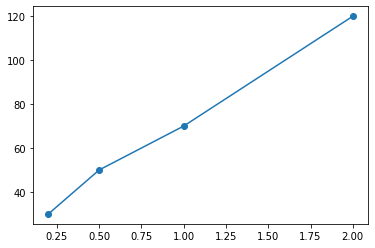

In [3]:
# I use different number of node points in my crystal scale for different c-rates. 
# This block of code just creates a function to figure out number of nodes needed for any arbitrary c-rate
# based on some node values I know work at different c-rates

crs = [0.2,0.5,1,2]
nodes = [30,50,70,120]

plt.plot(crs,nodes,'-o')

f = np.poly1d(np.polyfit(crs,nodes,1))

I will use Sobol sampling (implemented using scipy) to create the samples I need in my design space. Specify `N_add`, the number of samples you want to add. If you have already done some sampling and want to do denser sampling, this code will add `N_add` simulations to your exisiting list of simulations

In [4]:
from scipy.stats import qmc
sampler = qmc.Sobol(d=len(ps), scramble=False)

In [5]:
# specify the number of ismulations you wan to add
N_add = 0

# this will just look for whether you have an existing simulation parameter table. 
# if so, it will add to it
# if not, it will create a new one

iterations = []
for file in os.listdir('10_training_set_params/'):
    if file.startswith('Simulation_Parameters'):
        iterations.append(int(file.split('_I')[1].split('.')[0]))

_ = sampler.reset()
if len(iterations)==0:
    
    sample = sampler.random(N_add)
    sample = qmc.scale(sample, l_bounds, u_bounds)
    
    new_iteration_filename = f'Simulation_Parameters_I0.csv'
    sim_table = pd.DataFrame(sample,columns=ps)
    
else:
    i = np.max(iterations)
    latest_iteration_filename = f'10_training_set_params/Simulation_Parameters_I{i}.csv'
    
    sample = pd.read_csv(latest_iteration_filename,sep=',',index_col=0)
    sample = sample[ps]
    print(f'{len(sample)} existing samples')
    
    _ = sampler.fast_forward(len(sample))
    sample_cont = sampler.random(N_add)
    sample_cont = qmc.scale(sample_cont, l_bounds, u_bounds)
    
    if len(sample_cont)>0:
        sample = np.concatenate([sample,sample_cont])
        i = i+1
    new_iteration_filename = f'10_training_set_params/Simulation_Parameters_I{i}.csv'
    sim_table =pd.DataFrame(sample,columns=ps)

1024 existing samples


In [6]:
# this just adds the nodes I need based on the c-rate function
sim_table['XTAL_NODES'] = f(sim_table['CRATE'].values).astype(int)

In [8]:
# save the simulation parameter table that was generated
sim_table.to_csv(new_iteration_filename,sep=',')

sim_table[target_ps].to_csv(f'10_training_set_params/targets_I{i}.csv',sep=',')

**Important**: always check the distribution of your parameters before simulating to make sure they are roughly uniform.

In [10]:
sample

,CRATE,AML_ADJ,DF_A,I0_A
0,0.100000,0.500000,-14.000000,-8.000000
1,1.050000,0.750000,-12.500000,-7.000000
2,1.525000,0.625000,-13.250000,-7.500000
3,0.575000,0.875000,-11.750000,-6.500000
4,0.812500,0.687500,-12.125000,-6.250000
...,...,...,...,...
1019,0.814355,0.813965,-13.288086,-6.458984
1020,0.576855,0.501465,-12.913086,-6.208984
1021,1.526855,0.751465,-11.413086,-7.208984
1022,1.051855,0.626465,-13.663086,-6.708984


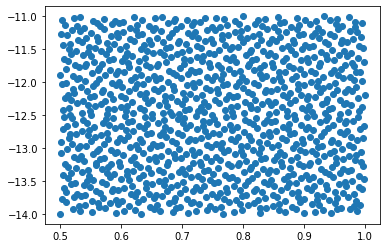

In [16]:
plt.scatter(sim_table['AML_ADJ'],sim_table['DF_A'])

(array([103., 102., 102., 103., 102., 102., 103., 102., 102., 103.]),
 array([0.5       , 0.54995117, 0.59990234, 0.64985352, 0.69980469,
        0.74975586, 0.79970703, 0.8496582 , 0.89960938, 0.94956055,
        0.99951172]),
 <a list of 10 Patch objects>)

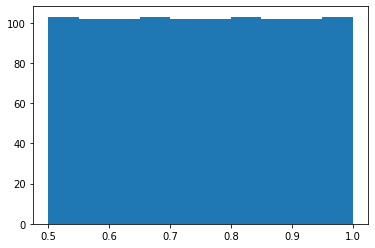

In [17]:
plt.hist(sim_table['AML_ADJ'])